## Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_toko = pd.read_csv('/content/drive/MyDrive/Datathon/Datathon_mie ayam rohimah - toko_generated.csv')
df_user = pd.read_csv('/content/drive/MyDrive/Datathon/Datathon_mie ayam rohimah - user_generated.csv')
df_video = pd.read_csv('/content/drive/MyDrive/Datathon/Datathon_mie ayam rohimah - video_generated.csv')

**Load Dataset**

In [4]:
df_toko.head()

,toko_id,lokasi,kategori,rating
0,1,Surabaya,Nasi Goreng,3.41
1,1,Surabaya,Sate,3.41
2,2,Medan,Ayam Bakar,3.70
3,2,Medan,Burger,3.70
4,2,Medan,Nasi Goreng,3.70


In [5]:
df_user.head()

,user_id,video_id,liked,distance,kategori,likes_video,toko_id,latitude,longitude
0,103,1087,1,4.63,Ayam Bakar,1620,67,-6.9667,110.4167
1,436,1203,0,1.87,Mie Ayam,1578,119,3.5952,98.6722
2,349,1015,1,1.50,Nasi Goreng,3963,128,-6.9667,110.4167
3,271,1150,1,3.64,Sate,2101,129,-7.7956,110.3695
4,107,1935,1,4.34,Bakso,1131,76,-6.9175,107.6191


In [6]:
df_video.head()

,video_id,likes_video,toko_id,kategori,duration
0,1000,3284,135,Bakso,44.8
1,1001,4444,87,Mie Ayam,244.5
2,1002,6709,183,Bakso,176.3
3,1003,8987,100,Ayam Bakar,296.6
4,1004,2802,63,Burger,120.7


**info dataset**

In [7]:
df_toko.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   toko_id   611 non-null    int64  
 1   lokasi    611 non-null    object 
 2   kategori  611 non-null    object 
 3   rating    611 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 19.2+ KB


In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      10000 non-null  int64  
 1   video_id     10000 non-null  int64  
 2   liked        10000 non-null  int64  
 3   distance     10000 non-null  float64
 4   kategori     10000 non-null  object 
 5   likes_video  10000 non-null  int64  
 6   toko_id      10000 non-null  int64  
 7   latitude     10000 non-null  float64
 8   longitude    10000 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 703.3+ KB


In [9]:
df_video.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   video_id     5000 non-null   int64  
 1   likes_video  5000 non-null   int64  
 2   toko_id      5000 non-null   int64  
 3   kategori     5000 non-null   object 
 4   duration     5000 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 195.4+ KB


#Preprocessing

In [10]:
df_video = df_video.rename(columns={"kategori": "kategori_video"})

In [11]:
df_toko = df_toko.rename(columns={"kategori": "kategori_toko"})

In [12]:
#Gabungan user dan video berdasarkan video_id:
df_merged = df_user.merge(
    df_video,
    on="video_id",
    suffixes=("", "_video")
)
print("\n===== Merge User + Video =====")
df_merged.head()


===== Merge User + Video =====


,user_id,video_id,liked,distance,kategori,likes_video,toko_id,latitude,longitude,likes_video_video,toko_id_video,kategori_video,duration
0,103,1087,1,4.63,Ayam Bakar,1620,67,-6.9667,110.4167,5621,21,Bakso,260.0
1,436,1203,0,1.87,Mie Ayam,1578,119,3.5952,98.6722,2624,23,Burger,246.1
2,349,1015,1,1.50,Nasi Goreng,3963,128,-6.9667,110.4167,3958,53,Sate,164.1
3,271,1150,1,3.64,Sate,2101,129,-7.7956,110.3695,3076,133,Mie Ayam,14.6
4,107,1935,1,4.34,Bakso,1131,76,-6.9175,107.6191,1133,73,Ayam Bakar,38.8


In [13]:
#Gabungkan hasil tadi dengan Toko berdasarkan toko_id
df_merged = df_merged.merge(
    df_toko,
    on="toko_id",
    suffixes=("", "_toko")
)
print("\n===== Merge Lengkap (User + Video + Toko) =====")
df_merged.head()


===== Merge Lengkap (User + Video + Toko) =====


,user_id,video_id,liked,distance,kategori,likes_video,toko_id,latitude,longitude,likes_video_video,toko_id_video,kategori_video,duration,lokasi,kategori_toko,rating
0,103,1087,1,4.63,Ayam Bakar,1620,67,-6.9667,110.4167,5621,21,Bakso,260.0,Jakarta,Burger,3.11
1,103,1087,1,4.63,Ayam Bakar,1620,67,-6.9667,110.4167,5621,21,Bakso,260.0,Jakarta,Ayam Bakar,3.11
2,436,1203,0,1.87,Mie Ayam,1578,119,3.5952,98.6722,2624,23,Burger,246.1,Medan,Ayam Bakar,3.02
3,436,1203,0,1.87,Mie Ayam,1578,119,3.5952,98.6722,2624,23,Burger,246.1,Medan,Nasi Goreng,3.02
4,436,1203,0,1.87,Mie Ayam,1578,119,3.5952,98.6722,2624,23,Burger,246.1,Medan,Mie Ayam,3.02


In [14]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32723 entries, 0 to 32722
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            32723 non-null  int64  
 1   video_id           32723 non-null  int64  
 2   liked              32723 non-null  int64  
 3   distance           32723 non-null  float64
 4   kategori           32723 non-null  object 
 5   likes_video        32723 non-null  int64  
 6   toko_id            32723 non-null  int64  
 7   latitude           32723 non-null  float64
 8   longitude          32723 non-null  float64
 9   likes_video_video  32723 non-null  int64  
 10  toko_id_video      32723 non-null  int64  
 11  kategori_video     32723 non-null  object 
 12  duration           32723 non-null  float64
 13  lokasi             32723 non-null  object 
 14  kategori_toko      32723 non-null  object 
 15  rating             32723 non-null  float64
dtypes: float64(5), int64(7

In [15]:
df_clean = df_merged[[
    "user_id",
    "video_id",
    "toko_id",
    "liked",
    "distance",
    "latitude",
    "longitude",
    "kategori_video",
    "likes_video_video",
    "duration",
    "lokasi",
    "kategori_toko",
    "rating"
]].copy()

In [16]:
df_clean = df_clean.rename(columns={
    "likes_video_video": "likes_video",
    "lokasi_toko": "lokasi",
    "kategori_toko_toko": "kategori_toko",
    "rating_toko": "rating"
})

In [17]:
print("Kolom dataframe bersih:")
df_clean.columns

Kolom dataframe bersih:


Index(['user_id', 'video_id', 'toko_id', 'liked', 'distance', 'latitude',
       'longitude', 'kategori_video', 'likes_video', 'duration', 'lokasi',
       'kategori_toko', 'rating'],
      dtype='object')

In [18]:
print("\nPreview 5 baris data:")
df_clean.head()


Preview 5 baris data:


,user_id,video_id,toko_id,liked,distance,latitude,longitude,kategori_video,likes_video,duration,lokasi,kategori_toko,rating
0,103,1087,67,1,4.63,-6.9667,110.4167,Bakso,5621,260.0,Jakarta,Burger,3.11
1,103,1087,67,1,4.63,-6.9667,110.4167,Bakso,5621,260.0,Jakarta,Ayam Bakar,3.11
2,436,1203,119,0,1.87,3.5952,98.6722,Burger,2624,246.1,Medan,Ayam Bakar,3.02
3,436,1203,119,0,1.87,3.5952,98.6722,Burger,2624,246.1,Medan,Nasi Goreng,3.02
4,436,1203,119,0,1.87,3.5952,98.6722,Burger,2624,246.1,Medan,Mie Ayam,3.02


In [19]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le_kategori_video = LabelEncoder()
le_kategori_toko = LabelEncoder()
le_lokasi = LabelEncoder()

# Encode kategori video
df_clean["kategori_video_enc"] = le_kategori_video.fit_transform(df_clean["kategori_video"])
# Encode kategori toko
df_clean["kategori_toko_enc"] = le_kategori_toko.fit_transform(df_clean["kategori_toko"])
# Encode lokasi
df_clean["lokasi_enc"] = le_lokasi.fit_transform(df_clean["lokasi"])

In [20]:
scaler = MinMaxScaler()

# Kolom numeric yang mau dinormalisasi
numeric_cols = ["distance", "latitude", "longitude", "likes_video", "duration", "rating"]
# Transform
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

In [21]:
print("\nKolom setelah encoding dan normalisasi:")
df_clean[["kategori_video", "kategori_video_enc", "kategori_toko", "kategori_toko_enc", "lokasi", "lokasi_enc"]].head()


Kolom setelah encoding dan normalisasi:


,kategori_video,kategori_video_enc,kategori_toko,kategori_toko_enc,lokasi,lokasi_enc
0,Bakso,1,Burger,2,Jakarta,1
1,Bakso,1,Ayam Bakar,0,Jakarta,1
2,Burger,2,Ayam Bakar,0,Medan,2
3,Burger,2,Nasi Goreng,4,Medan,2
4,Burger,2,Mie Ayam,3,Medan,2


In [22]:
print("\nKolom numeric setelah normalisasi:")
df_clean[numeric_cols].head()


Kolom numeric setelah normalisasi:


,distance,latitude,longitude,likes_video,duration,rating
0,0.917778,0.072769,0.833144,0.557375,0.863322,0.055276
1,0.917778,0.072769,0.833144,0.557375,0.863322,0.055276
2,0.304444,1.000000,0.000000,0.254373,0.815225,0.010050
3,0.304444,1.000000,0.000000,0.254373,0.815225,0.010050
4,0.304444,1.000000,0.000000,0.254373,0.815225,0.010050


#Splitting

In [23]:
# Target
y = df_clean["liked"]

# Feature columns
feature_cols = [
    "user_id",
    "video_id",
    "toko_id",
    "distance",
    "latitude",
    "longitude",
    "likes_video",
    "duration",
    "rating",
    "kategori_video_enc",
    "kategori_toko_enc",
    "lokasi_enc"
]

X = df_clean[feature_cols]

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 26178
Test size: 6545


#Model Preparation

In [25]:
# Convert DataFrame ke dictionary of arrays
X_train_dict = {col: X_train[col].values for col in X_train.columns}
X_test_dict = {col: X_test[col].values for col in X_test.columns}

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Embedding Inputs
user_input = Input(shape=(1,), name="user_id")
video_input = Input(shape=(1,), name="video_id")
toko_input = Input(shape=(1,), name="toko_id")

# Categorical Encoded Inputs
kategori_video_input = Input(shape=(1,), name="kategori_video_enc")
kategori_toko_input = Input(shape=(1,), name="kategori_toko_enc")
lokasi_input = Input(shape=(1,), name="lokasi_enc")

# Numeric Inputs
distance_input = Input(shape=(1,), name="distance")
latitude_input = Input(shape=(1,), name="latitude")
longitude_input = Input(shape=(1,), name="longitude")
likes_video_input = Input(shape=(1,), name="likes_video")
duration_input = Input(shape=(1,), name="duration")
rating_input = Input(shape=(1,), name="rating")

embedding_dim = 8

user_emb = layers.Embedding(input_dim=10000, output_dim=embedding_dim)(user_input)
video_emb = layers.Embedding(input_dim=10000, output_dim=embedding_dim)(video_input)
toko_emb = layers.Embedding(input_dim=1000, output_dim=embedding_dim)(toko_input)

kategori_video_emb = layers.Embedding(input_dim=10, output_dim=4)(kategori_video_input)
kategori_toko_emb = layers.Embedding(input_dim=10, output_dim=4)(kategori_toko_input)
lokasi_emb = layers.Embedding(input_dim=10, output_dim=4)(lokasi_input)

user_emb_flat = layers.Flatten()(user_emb)
video_emb_flat = layers.Flatten()(video_emb)
toko_emb_flat = layers.Flatten()(toko_emb)
kategori_video_emb_flat = layers.Flatten()(kategori_video_emb)
kategori_toko_emb_flat = layers.Flatten()(kategori_toko_emb)
lokasi_emb_flat = layers.Flatten()(lokasi_emb)

concat_layer = layers.Concatenate()([
    user_emb_flat,
    video_emb_flat,
    toko_emb_flat,
    kategori_video_emb_flat,
    kategori_toko_emb_flat,
    lokasi_emb_flat,
    distance_input,
    latitude_input,
    longitude_input,
    likes_video_input,
    duration_input,
    rating_input
])

dense1 = layers.Dense(64, activation="relu")(concat_layer)
dense2 = layers.Dense(32, activation="relu")(dense1)
output = layers.Dense(1, activation="sigmoid")(dense2)

In [27]:
model = Model(
    inputs=[
        user_input,
        video_input,
        toko_input,
        kategori_video_input,
        kategori_toko_input,
        lokasi_input,
        distance_input,
        latitude_input,
        longitude_input,
        likes_video_input,
        duration_input,
        rating_input
    ],
    outputs=output
)

In [28]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["AUC"]
)

In [29]:
print("\nData types di X_train_dict:")
for k, v in X_train_dict.items():
    print(f"{k}: {v.dtype}")


Data types di X_train_dict:
user_id: int64
video_id: int64
toko_id: int64
distance: float64
latitude: float64
longitude: float64
likes_video: float64
duration: float64
rating: float64
kategori_video_enc: int64
kategori_toko_enc: int64
lokasi_enc: int64


In [30]:
# Convert embeddings columns ke int32
embed_cols = ["user_id", "video_id", "toko_id", "kategori_video_enc", "kategori_toko_enc", "lokasi_enc"]
for col in embed_cols:
    X_train_dict[col] = X_train_dict[col].astype("int32")
    X_test_dict[col] = X_test_dict[col].astype("int32")

# Convert numeric columns ke float32
numeric_cols = ["distance", "latitude", "longitude", "likes_video", "duration", "rating"]
for col in numeric_cols:
    X_train_dict[col] = X_train_dict[col].astype("float32")
    X_test_dict[col] = X_test_dict[col].astype("float32")

In [31]:
print("\nSetelah konversi dtype:")
for k, v in X_train_dict.items():
    print(f"{k}: {v.dtype}")


Setelah konversi dtype:
user_id: int32
video_id: int32
toko_id: int32
distance: float32
latitude: float32
longitude: float32
likes_video: float32
duration: float32
rating: float32
kategori_video_enc: int32
kategori_toko_enc: int32
lokasi_enc: int32


#train model

In [32]:
history = model.fit(
    X_train_dict,
    y_train,
    validation_data=(X_test_dict, y_test),
    epochs=20,
    batch_size=512
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 0.5137 - loss: 0.6771 - val_AUC: 0.5426 - val_loss: 0.6685
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6106 - loss: 0.6618 - val_AUC: 0.6556 - val_loss: 0.6469
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7174 - loss: 0.6183 - val_AUC: 0.6843 - val_loss: 0.6219
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.7511 - loss: 0.5726 - val_AUC: 0.7040 - val_loss: 0.6121
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.7768 - loss: 0.5507 - val_AUC: 0.7237 - val_loss: 0.5971
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8091 - loss: 0.5225 - val_AUC: 0.7407 - val_loss: 0.5862
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8215 - loss: 0.5060 - val_AUC: 0.7592 - val_loss: 0.5695
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8477 - loss: 0.4726 - val_AUC: 0.7786 - val_loss: 0.5506
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8647 - los

#Evaluasi

In [33]:
results = model.evaluate(X_test_dict, y_test, verbose=2)
print("Test Loss:", results[0])
print("Test AUC :", results[1])

205/205 - 0s - 2ms/step - AUC: 0.9766 - loss: 0.1889
Test Loss: 0.18892455101013184
Test AUC : 0.9765638113021851


In [34]:
# Prediksi probabilitas
y_pred_proba = model.predict(X_test_dict).flatten()

# Thresholding: jika prob > 0.5 dianggap "like"
y_pred_label = (y_pred_proba >= 0.5).astype(int)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Confusion Matrix:
 [[3814  151]
 [ 119 2461]]


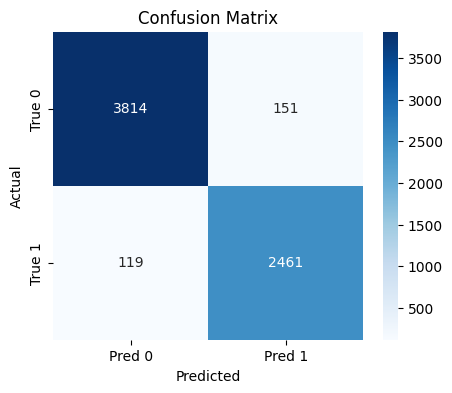


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      3965
           1       0.94      0.95      0.95      2580

    accuracy                           0.96      6545
   macro avg       0.96      0.96      0.96      6545
weighted avg       0.96      0.96      0.96      6545



In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_label)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_label)
print("\nClassification Report:\n", report)

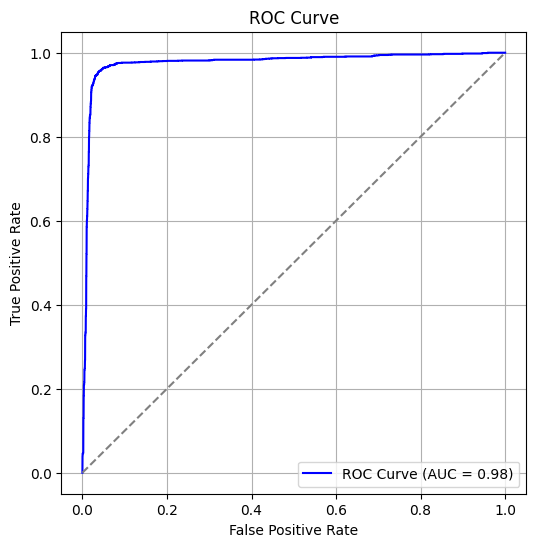

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

#Inference

In [37]:
def recommend_top_n(
    model,
    target_user_id,
    df_video,
    df_toko,
    le_kategori_video,
    le_kategori_toko,
    le_lokasi,
    scaler,
    top_n=5
):
    import numpy as np
    import pandas as pd

    # Siapkan video
    candidates = df_video.copy()
    candidates["user_id"] = target_user_id

    # Join ke toko
    candidates = candidates.merge(
        df_toko[["toko_id", "kategori_toko", "lokasi", "rating"]],
        on="toko_id",
        how="left"
    )

    # Encode kategori video
    candidates["kategori_video_enc"] = le_kategori_video.transform(candidates["kategori_video"])

    # Encode kategori toko
    candidates["kategori_toko_enc"] = le_kategori_toko.transform(candidates["kategori_toko"])

    # Encode lokasi
    candidates["lokasi_enc"] = le_lokasi.transform(candidates["lokasi"])

    # Dummy distance, lat, long
    candidates["distance"] = 0.0
    candidates["latitude"] = 0.0
    candidates["longitude"] = 0.0

    # Normalisasi numeric
    numeric_cols = ["distance", "latitude", "longitude", "likes_video", "duration", "rating"]
    candidates[numeric_cols] = scaler.transform(candidates[numeric_cols])

    # Siapkan input dictionary
    X_input = {}
    input_names = [
        "user_id",
        "video_id",
        "toko_id",
        "kategori_video_enc",
        "kategori_toko_enc",
        "lokasi_enc",
        "distance",
        "latitude",
        "longitude",
        "likes_video",
        "duration",
        "rating",
    ]

    for col in input_names:
        arr = candidates[col].to_numpy().astype(np.float32 if col in numeric_cols else np.int32)
        X_input[col] = arr.reshape(-1, 1)

    # Debug print
    for k, v in X_input.items():
        print(f"{k}: shape={v.shape}, dtype={v.dtype}")

    # Siapkan input list sesuai urutan Input() di model
    X_input_list = [
        X_input["user_id"],
        X_input["video_id"],
        X_input["toko_id"],
        X_input["kategori_video_enc"],
        X_input["kategori_toko_enc"],
        X_input["lokasi_enc"],
        X_input["distance"],
        X_input["latitude"],
        X_input["longitude"],
        X_input["likes_video"],
        X_input["duration"],
        X_input["rating"],
    ]

    # Prediksi
    preds = model.predict(X_input_list, verbose=0).flatten()
    candidates["prob_like"] = preds

    # Top N
    top_n_df = candidates.sort_values("prob_like", ascending=False).head(top_n)

    return top_n_df[["video_id", "toko_id", "kategori_video", "kategori_toko", "lokasi", "prob_like"]]

In [38]:
print(df_video.columns)
print(df_toko.columns)

Index(['video_id', 'likes_video', 'toko_id', 'kategori_video', 'duration'], dtype='object')
Index(['toko_id', 'lokasi', 'kategori_toko', 'rating'], dtype='object')


In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ video_id            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ toko_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kategori_video_enc  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kategori_toko_enc   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lokasi_enc          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │     80,000 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │     80,000 │ video_id[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 8)      │      8,000 │ toko_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 4)      │         40 │ kategori_video_e… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 4)      │         40 │ kategori_toko_en… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 4)      │         40 │ lokasi_enc[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4)         │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4)         │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 4)         │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance            │ (None, 1)         │          0 │ -               

 Total params: 518,957 (1.98 MB)

 Trainable params: 172,985 (675.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 345,972 (1.32 MB)

In [40]:
# Ambil 1 baris saja dari df_video
sample_df = df_video.head(1).copy()
sample_df["user_id"] = 103

# Join toko
sample_df = sample_df.merge(
    df_toko[["toko_id", "kategori_toko", "lokasi", "rating"]],
    on="toko_id",
    how="left"
)

# Encode
sample_df["kategori_video_enc"] = le_kategori_video.transform(sample_df["kategori_video"])
sample_df["kategori_toko_enc"] = le_kategori_toko.transform(sample_df["kategori_toko"])
sample_df["lokasi_enc"] = le_lokasi.transform(sample_df["lokasi"])

# Dummy numeric
sample_df["distance"] = 0.0
sample_df["latitude"] = 0.0
sample_df["longitude"] = 0.0

# Normalisasi
numeric_cols = ["distance", "latitude", "longitude", "likes_video", "duration", "rating"]
sample_df[numeric_cols] = scaler.transform(sample_df[numeric_cols])

# Build X_input
X_sample = {}
input_names = [
    "user_id",
    "video_id",
    "toko_id",
    "kategori_video_enc",
    "kategori_toko_enc",
    "lokasi_enc",
    "distance",
    "latitude",
    "longitude",
    "likes_video",
    "duration",
    "rating",
]

for col in input_names:
    arr = sample_df[col].to_numpy().astype(np.float32 if col in numeric_cols else np.int32)
    X_sample[col] = arr.reshape(-1, 1)

for k, v in X_sample.items():
    print(f"{k}: shape={v.shape}, dtype={v.dtype}, has_nan={np.isnan(v).any()}")
    print(v[:5])

# Predict
X_sample_list = [
    X_sample["user_id"],
    X_sample["video_id"],
    X_sample["toko_id"],
    X_sample["kategori_video_enc"],
    X_sample["kategori_toko_enc"],
    X_sample["lokasi_enc"],
    X_sample["distance"],
    X_sample["latitude"],
    X_sample["longitude"],
    X_sample["likes_video"],
    X_sample["duration"],
    X_sample["rating"],
]

pred = model.predict(X_sample_list)
print("Prediksi sukses:", pred)

user_id: shape=(3, 1), dtype=int32, has_nan=False
[[103]
 [103]
 [103]]
video_id: shape=(3, 1), dtype=int32, has_nan=False
[[1000]
 [1000]
 [1000]]
toko_id: shape=(3, 1), dtype=int32, has_nan=False
[[135]
 [135]
 [135]]
kategori_video_enc: shape=(3, 1), dtype=int32, has_nan=False
[[1]
 [1]
 [1]]
kategori_toko_enc: shape=(3, 1), dtype=int32, has_nan=False
[[3]
 [1]
 [5]]
lokasi_enc: shape=(3, 1), dtype=int32, has_nan=False
[[3]
 [3]
 [3]]
distance: shape=(3, 1), dtype=float32, has_nan=False
[[-0.11111111]
 [-0.11111111]
 [-0.11111111]]
latitude: shape=(3, 1), dtype=float32, has_nan=False
[[0.68437684]
 [0.68437684]
 [0.68437684]]
longitude: shape=(3, 1), dtype=float32, has_nan=False
[[-6.9997163]
 [-6.9997163]
 [-6.9997163]]
likes_video: shape=(3, 1), dtype=float32, has_nan=False
[[0.3211]
 [0.3211]
 [0.3211]]
duration: shape=(3, 1), dtype=float32, has_nan=False
[[0.11868512]
 [0.11868512]
 [0.11868512]]
rating: shape=(3, 1), dtype=float32, has_nan=False
[[0.08542714]
 [0.08542714]
 [0.

In [42]:
top_recommendations = recommend_top_n(
    model=model,
    target_user_id=103,
    df_video=df_video,
    df_toko=df_toko,
    le_kategori_video=le_kategori_video,
    le_kategori_toko=le_kategori_toko,
    le_lokasi=le_lokasi,
    scaler=scaler,
    top_n=5
)

print(top_recommendations)

user_id: shape=(15141, 1), dtype=int32
video_id: shape=(15141, 1), dtype=int32
toko_id: shape=(15141, 1), dtype=int32
kategori_video_enc: shape=(15141, 1), dtype=int32
kategori_toko_enc: shape=(15141, 1), dtype=int32
lokasi_enc: shape=(15141, 1), dtype=int32
distance: shape=(15141, 1), dtype=float32
latitude: shape=(15141, 1), dtype=float32
longitude: shape=(15141, 1), dtype=float32
likes_video: shape=(15141, 1), dtype=float32
duration: shape=(15141, 1), dtype=float32
rating: shape=(15141, 1), dtype=float32
       video_id  toko_id kategori_video kategori_toko      lokasi  prob_like
15140      5999      174         Burger          Sate  Yogyakarta        1.0
0          1000      135          Bakso      Mie Ayam    Semarang        1.0
1          1000      135          Bakso         Bakso    Semarang        1.0
2          1000      135          Bakso          Sate    Semarang        1.0
3          1001       87       Mie Ayam      Mie Ayam    Semarang        1.0


In [44]:
model.save('rekomendasi_model.h5')

In [47]:
import joblib
joblib.dump(le_kategori_video, "le_kategori_video.pkl")
joblib.dump(le_kategori_toko, "le_kategori_toko.pkl")
joblib.dump(le_lokasi, "le_lokasi.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']